# Experimentos para el preprocesamiento de los datos y arquitectura del modelo.
En este cuaderno se van a realizara un exploracion del dataset de las anotsaciones de esqueletos 2d y también se experimentara con distintas arquitecturas. 

In [4]:
# Create a DataFrame summary and a PyTorch Dataset for UCF101 2D skeletons
# This cell loads the pickle, creates a short DataFrame for easier inspection,
# and defines UCFSkeletonDataset which returns a chosen person's keypoints as a tensor.
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

# Load the pickle file
ucfdataset = 'Dataset/2d-skels/ucf101_2d.pkl'
with open(ucfdataset, 'rb') as f:
    ucf_data = pickle.load(f)

annotations = ucf_data.get('annotations', [])

# Build a compact DataFrame that summarizes each annotation for quick inspection
rows = []
for ann in annotations:
    kp = ann.get('keypoint')
    kp_shape = None
    try:
        if kp is not None:
            kp_shape = np.array(kp).shape
    except Exception:
        kp_shape = None
    rows.append({
        'frame_dir': ann.get('frame_dir'),
        'total_frames': ann.get('total_frames'),
        'img_shape': ann.get('img_shape'),
        'original_shape': ann.get('original_shape'),
        'label': int(ann.get('label')) if ann.get('label') is not None else None,
        'keypoint_shape': kp_shape,
        'has_keypoint_score': ('keypoint_score' in ann) and (ann.get('keypoint_score') is not None)
    })

df_ann = pd.DataFrame(rows)
# Save a CSV summary for quick external inspection
csv_path = 'annotations_summary.csv'
df_ann.to_csv(csv_path, index=False)
print(f"Saved annotations summary to {csv_path}")

# --- Transforms (pipeline) ---
class Compose:
    def __init__(self, transforms):
        self.transforms = list(transforms)
    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

class NormalizeKeypoints:
    """Normalize keypoints to unit coordinates using image shape.

    Expects sample to contain 'keypoint' (torch.Tensor (T,V,C)) and either
    'img_shape' or 'original_shape' (height, width) in the annotation metadata.
    """
    def __init__(self, shape_key='img_shape'):
        self.shape_key = shape_key

    def __call__(self, sample):
        kp = sample['keypoint']
        shape = sample.get(self.shape_key) or sample.get('original_shape')
        if shape is None:
            return sample
        try:
            h, w = float(shape[0]), float(shape[1])
            if w > 0 and h > 0:
                kp = kp.clone()
                # assume kp[...,0]=x, kp[...,1]=y
                kp[..., 0] = kp[..., 0] / w
                kp[..., 1] = kp[..., 1] / h
                sample['keypoint'] = kp
        except Exception:
            pass
        return sample

# Define a Dataset wrapper (no inline normalization — accepts transform)
class UCFSkeletonDataset(Dataset):
    """Dataset wrapping the annotations list from ucf101_2d.pkl.
    For samples with multiple persons (M>1) and keypoint_score available,
    it selects the person with highest mean keypoint_score. Otherwise selects person 0.

    The dataset accepts an optional `transform` callable which receives and returns
    the sample dict. This keeps normalization/augmentation separate from I/O.
    """
    def __init__(self, annotations_list, transform=None, select_best_by_score=True, dtype=torch.float32):
        self.annotations = annotations_list
        self.transform = transform
        self.select_best_by_score = select_best_by_score
        self.dtype = dtype

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        kp = ann.get('keypoint')
        kp_score = ann.get('keypoint_score', None)

        # ensure numpy
        kp = np.array(kp)  # M x T x V x C

        if kp.ndim != 4:
            raise ValueError(f"Unexpected keypoint shape for idx={idx}: {kp.shape}")

        M = kp.shape[0]

        # choose person
        person_idx = 0
        if M > 1 and kp_score is not None and self.select_best_by_score:
            scores = np.array(kp_score)  # M x T x V
            mean_scores = scores.mean(axis=(1,2))
            person_idx = int(mean_scores.argmax())

        person_kp = kp[person_idx]  # T x V x C

        # convert to torch tensor
        tensor_kp = torch.from_numpy(person_kp.astype(np.float32))

        sample = {
            'keypoint': tensor_kp,  # (T, V, C)
            'label': int(ann.get('label')) if ann.get('label') is not None else None,
            'frame_dir': ann.get('frame_dir'),
            'total_frames': ann.get('total_frames'),
            'img_shape': ann.get('img_shape'),
            'original_shape': ann.get('original_shape')
        }

        if kp_score is not None:
            score_np = np.array(kp_score)[person_idx]  # T x V
            sample['score'] = torch.from_numpy(score_np.astype(np.float32))

        # apply transform if provided
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

# Create a Normalize transform and dataset instance (transform applied externally)
normalize = NormalizeKeypoints(shape_key='img_shape')
ucf_dataset = UCFSkeletonDataset(annotations, transform=normalize)

# Quick checks / example
print(f"Loaded {len(annotations)} annotations. df_ann shape: {df_ann.shape}")
print(df_ann.head())
if len(ucf_dataset) > 0:
    s = ucf_dataset[0]
    print('\nExample sample keys:', list(s.keys()))
    print('keypoint tensor shape (T, V, C):', s['keypoint'].shape)
    # show a couple normalized coordinate values (if img_shape exists)
    print('example coords (first frame, first joint):', s['keypoint'][0,0])
    if 'score' in s:
        print('score tensor shape (T, V):', s['score'].shape)
    print('label:', s['label'])
else:
    print('Dataset is empty.')

# -- Collate / padding helpers for DataLoader batching --

def pad_sequence_kp(kps):
    """Pad a list of keypoint tensors [(T, V, C), ...] to (B, T_max, V, C).
    Returns (padded_kps, mask) where mask is (B, T_max, V) with 1 for real frames.
    """
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded = []
    masks = []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([t, pad_tensor], dim=0)
            mask = torch.cat([torch.ones((T, V)), torch.zeros((pad_len, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)  # (B, T_max, V, C)
    batch_mask = torch.stack(masks, dim=0)  # (B, T_max, V)
    return batch_kp, batch_mask


def ucf_collate_fn(batch):
    """Collate function for UCFSkeletonDataset.
    Produces:
      - 'keypoint': (B, T, V, C)
      - 'mask': (B, T, V)
      - 'label': (B,)
      - 'frame_dir', 'total_frames'
      - 'score': (B, T, V) or None
    """
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]

    batch_kp, batch_mask = pad_sequence_kp(kps)

    batch_scores = None
    if any(s is not None for s in scores):
        # replace None with zeros of matching shape before padding
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        # pad scores to (B, T_max, V)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([s, pad], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)

    return {
        'keypoint': batch_kp,
        'mask': batch_mask,
        'label': labels,
        'frame_dir': frame_dirs,
        'total_frames': total_frames,
        'score': batch_scores
    }

# Example usage with DataLoader
from torch.utils.data import DataLoader
loader = DataLoader(ucf_dataset, batch_size=4, shuffle=False, collate_fn=ucf_collate_fn)
for batch in loader:
    print('Batch keypoint shape:', batch['keypoint'].shape)  # (B, T, V, C)
    print('Batch mask shape:', batch['mask'].shape)          # (B, T, V)
    print('Labels shape:', batch['label'].shape)
    if batch['score'] is not None:
        print('Score shape:', batch['score'].shape)
    break


Saved annotations summary to annotations_summary.csv
Loaded 13320 annotations. df_ann shape: (13320, 7)
                  frame_dir  total_frames   img_shape original_shape  label  \
0  v_ApplyEyeMakeup_g08_c01           119  (256, 340)     (256, 340)      0   
1  v_ApplyEyeMakeup_g08_c02           116  (256, 340)     (256, 340)      0   
2  v_ApplyEyeMakeup_g08_c03           145  (256, 340)     (256, 340)      0   
3  v_ApplyEyeMakeup_g08_c04           223  (256, 340)     (256, 340)      0   
4  v_ApplyEyeMakeup_g08_c05           275  (256, 340)     (256, 340)      0   

    keypoint_shape  has_keypoint_score  
0  (1, 119, 17, 2)                True  
1  (1, 116, 17, 2)                True  
2  (1, 145, 17, 2)                True  
3  (2, 223, 17, 2)                True  
4  (1, 275, 17, 2)                True  

Example sample keys: ['keypoint', 'label', 'frame_dir', 'total_frames', 'img_shape', 'original_shape', 'score']
keypoint tensor shape (T, V, C): torch.Size([119, 17, 2])
exam

In [5]:
# Minimal training loop using the provided LSTM baseline
# Integrates Models/lstm_model.py, creates train/val splits, and runs 1 epoch.
import sys
import os
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ensure project root is importable
proj_root = Path('.').resolve()
if str(proj_root) not in sys.path:
    sys.path.append(str(proj_root))

# import the LSTM model
from Models.lstm_model import SkeletonLSTM

# Build a simple train/val split (try stratified split with sklearn if available)
labels = df_ann['label'].values
indices = df_ann.index.values

try:
    from sklearn.model_selection import train_test_split
    train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)
except Exception:
    # fallback: random split
    rng = np.random.RandomState(42)
    perm = rng.permutation(len(indices))
    split = int(0.8 * len(indices))
    train_idx = indices[perm[:split]]
    val_idx = indices[perm[split:]]

# subset annotations using indices
train_anns = [annotations[i] for i in train_idx]
val_anns = [annotations[i] for i in val_idx]

# Right-padding collate so the LSTM's last output corresponds to the actual last frame
def pad_sequence_kp_right(kps):
    T_max = max(t.shape[0] for t in kps)
    V = kps[0].shape[1]
    C = kps[0].shape[2]
    padded = []
    masks = []
    for t in kps:
        T = t.shape[0]
        pad_len = T_max - T
        if pad_len > 0:
            pad_tensor = torch.zeros((pad_len, V, C), dtype=t.dtype)
            p = torch.cat([pad_tensor, t], dim=0)  # left-pad
            mask = torch.cat([torch.zeros((pad_len, V)), torch.ones((T, V))], dim=0)
        else:
            p = t
            mask = torch.ones((T, V))
        padded.append(p)
        masks.append(mask)
    batch_kp = torch.stack(padded, dim=0)
    batch_mask = torch.stack(masks, dim=0)
    return batch_kp, batch_mask

def ucf_collate_fn_right(batch):
    kps = [item['keypoint'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    frame_dirs = [item['frame_dir'] for item in batch]
    total_frames = [item['total_frames'] for item in batch]
    scores = [item.get('score') for item in batch]

    batch_kp, batch_mask = pad_sequence_kp_right(kps)

    batch_scores = None
    if any(s is not None for s in scores):
        scores_repl = []
        for i, s in enumerate(scores):
            if s is None:
                T = kps[i].shape[0]
                V = kps[i].shape[1]
                scores_repl.append(torch.zeros((T, V), dtype=torch.float32))
            else:
                scores_repl.append(s)
        T_max = batch_kp.shape[1]
        padded_scores = []
        for s in scores_repl:
            pad_len = T_max - s.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, s.shape[1]), dtype=s.dtype)
                padded_scores.append(torch.cat([pad, s], dim=0))
            else:
                padded_scores.append(s)
        batch_scores = torch.stack(padded_scores, dim=0)

    return {
        'keypoint': batch_kp,
        'mask': batch_mask,
        'label': labels,
        'frame_dir': frame_dirs,
        'total_frames': total_frames,
        'score': batch_scores
    }

# Create datasets and loaders
train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
val_ds = UCFSkeletonDataset(val_anns, transform=normalize)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=ucf_collate_fn_right)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=ucf_collate_fn_right)

# Create model
num_classes = int(df_ann['label'].nunique())
model = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Minimal training: 1 epoch to verify everything runs
n_epochs = 1
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)  # (B, T, V, C)
        labels_b = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model(kp)
            loss = criterion(logits, labels_b)
            val_loss += loss.item() * labels_b.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels_b).sum().item()
            val_total += labels_b.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Save a small checkpoint
ckpt_path = 'lstm_minimal_checkpoint.pt'
torch.save({'model_state': model.state_dict(), 'num_classes': num_classes}, ckpt_path)
print('Saved checkpoint to', ckpt_path)


Epoch 1: train_loss=4.1983, train_acc=0.0411, val_loss=3.8400, val_acc=0.0691
Saved checkpoint to lstm_minimal_checkpoint.pt


Loaded checkpoint lstm_minimal_checkpoint.pt
Using existing train_loader / val_loader
Epoch 1: train_loss=3.6752, train_acc=0.0943, val_loss=3.4429, val_acc=0.1288
Epoch 1: train_loss=3.6752, train_acc=0.0943, val_loss=3.4429, val_acc=0.1288
Epoch 2: train_loss=3.4952, train_acc=0.1162, val_loss=3.4611, val_acc=0.1250
Epoch 2: train_loss=3.4952, train_acc=0.1162, val_loss=3.4611, val_acc=0.1250
Epoch 3: train_loss=3.2185, train_acc=0.1579, val_loss=3.0050, val_acc=0.1963
Epoch 3: train_loss=3.2185, train_acc=0.1579, val_loss=3.0050, val_acc=0.1963
Epoch 4: train_loss=3.0209, train_acc=0.1809, val_loss=2.9646, val_acc=0.2113
Epoch 4: train_loss=3.0209, train_acc=0.1809, val_loss=2.9646, val_acc=0.2113
Epoch 5: train_loss=2.8976, train_acc=0.2115, val_loss=2.7332, val_acc=0.2549
Saved checkpoint to lstm_trained.pt
Saved training history to training_history.csv
Epoch 5: train_loss=2.8976, train_acc=0.2115, val_loss=2.7332, val_acc=0.2549
Saved checkpoint to lstm_trained.pt
Saved training 

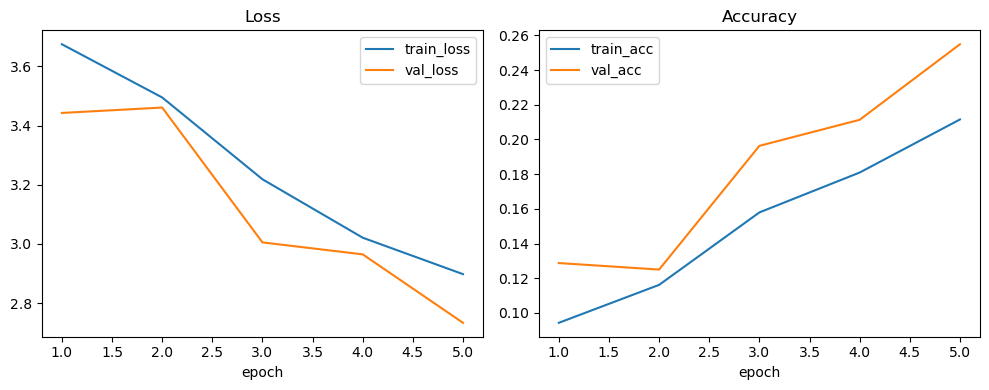

In [6]:
# Continue training (extended) from checkpoint, log metrics and plot results
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (adjust as needed)
n_epochs = 5
save_ckpt = 'lstm_trained.pt'
history_csv = 'training_history.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate model and load minimal checkpoint if present
from Models.lstm_model import SkeletonLSTM
num_classes = int(df_ann['label'].nunique())
model_ext = SkeletonLSTM(num_joints=17, in_channels=2, num_classes=num_classes)
if os.path.exists('lstm_minimal_checkpoint.pt'):
    ckpt = torch.load('lstm_minimal_checkpoint.pt', map_location=device)
    model_ext.load_state_dict(ckpt['model_state'])
    print('Loaded checkpoint lstm_minimal_checkpoint.pt')
else:
    print('No minimal checkpoint found; starting from scratch')

model_ext.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ext.parameters(), lr=1e-3)

# Use existing DataLoaders if present; otherwise recreate (lighter params)
try:
    train_loader
    val_loader
    print('Using existing train_loader / val_loader')
except NameError:
    print('Recreating DataLoaders (may be slower)')
    train_ds = UCFSkeletonDataset(train_anns, transform=normalize)
    val_ds = UCFSkeletonDataset(val_anns, transform=normalize)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=ucf_collate_fn_right)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=ucf_collate_fn_right)

# Training loop
history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(1, n_epochs+1):
    model_ext.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in train_loader:
        kp = batch['keypoint'].to(device)
        labels_b = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model_ext(kp)
        loss = criterion(logits, labels_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels_b.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels_b).sum().item()
        running_total += labels_b.size(0)
    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    model_ext.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            kp = batch['keypoint'].to(device)
            labels_b = batch['label'].to(device)
            logits = model_ext(kp)
            loss = criterion(logits, labels_b)
            val_loss += loss.item() * labels_b.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels_b).sum().item()
            val_total += labels_b.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# Save checkpoint and history
torch.save({'model_state': model_ext.state_dict(), 'num_classes': num_classes}, save_ckpt)
print('Saved checkpoint to', save_ckpt)

hist_df = pd.DataFrame(history)
hist_df.to_csv(history_csv, index=False)
print('Saved training history to', history_csv)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train_loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist_df['epoch'], hist_df['train_acc'], label='train_acc')
plt.plot(hist_df['epoch'], hist_df['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()
